In [1]:
#!pip install scikit-commpy
#!pip install ipywidgets

In [2]:
#!pip install numpy


In [3]:
#!pip install matplotlib

In [4]:
#!pip install PyQt5
!pwd

/home/xy/projects/jupyter/signal_processing


In [5]:
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from PyQt5.QtCore import Qt


In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cmath
import math
from commpy.filters import rcosfilter
from ipywidgets import interact, widgets

In [7]:
def resampling_lagrange(s, p, q, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    if (p > 1):
        if (q == 1):
            y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
        else:
            y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    else:
        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)

    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    for k in range(len(y)):
        x = k * q / p - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1

        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    return y


In [8]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)
    plt.figure(figure_counter)
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    return yf

In [9]:
def gen_rcfilter_impulse_response(n, fs):
    s_psf = rcosfilter(n * fs, alpha=0.24, Ts=1, Fs=fs)[1][1:]
    plt.figure()
    plt.plot(s_psf, '*-')
    plt.grid()
    plt.title('RC filter impulse response')
    plt.show()
    return s_psf

In [10]:
def add_freq(sig, f0_to_fsig):
    n = np.arange(0, len(sig), 1)
    mixer = np.exp(1j * 2 * np.pi * f0_to_fsig * n)
    return sig * mixer

In [11]:
def add_phase(sig, phase):
# phase = [-1, 1] [semicircles]
    sig *= np.exp(1j * np.pi * phase)
    return sig

In [12]:
def gen_qpsk_symbols(n_symb, fs):
    # create IQ of QPSK
    # complex array: [(1 + 1j, 1 -1j, ..., -1 -1j)]
    data = np.random.randint(0, 4, n_symb)
    #x_tr = x.transpose()
    y = [-1 - 1j, -1 + 1j, 1 - 1j, 1 + 1j]
    iq = [y[val] for val in data]
    iq_ups = np.zeros(N * fs, dtype=complex)
    iq_ups[:len(iq) * fs:fs] = iq
    return iq_ups

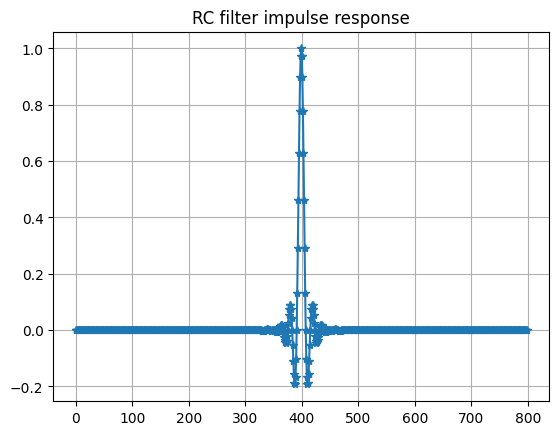

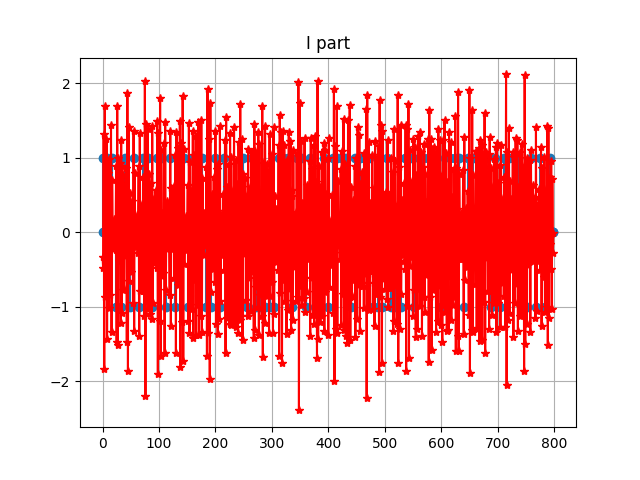

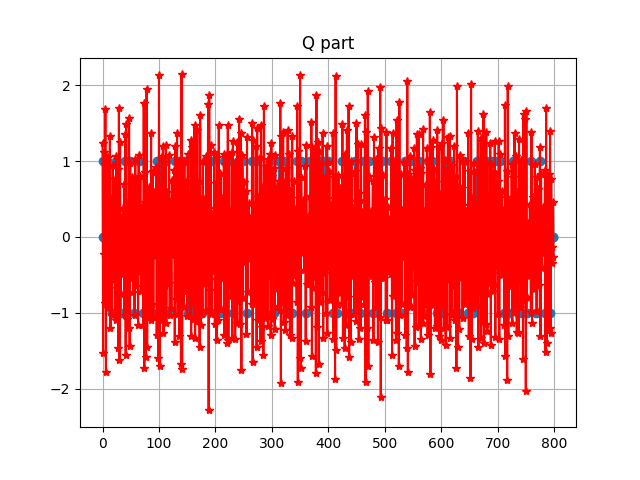

In [13]:
N = 100
Fs = 8 # f_sampling / f_symbol (SPS)
f0 = 3.2 # f_carrier / f_symbol
phase_0 = 3 / 9 # semicircles
delay = 0.1

s_rc = gen_rcfilter_impulse_response(N, Fs)
s_qpsk = gen_qpsk_symbols(N, Fs)
#s_qpsk_with_carr = add_freq(s_qpsk, f0 / Fs)
#global qpsk_filtered
qpsk_filtered = np.convolve(s_qpsk, s_rc, 'same')
# ----- Add delay -----
p = 1
q = 1
x0 = delay # it is negative delay
global s_rc_re_delay 
#lobal qpsk_filtered
qpsk_filtered = resampling_lagrange(qpsk_filtered, p, q, x0) # qpsk_filt_del

# ----- Add Carrier and initial phase -----
qpsk_filtered = add_phase(qpsk_filtered, phase_0)
qpsk_filtered = add_freq(qpsk_filtered, f0 / Fs)

import ipympl
%matplotlib inline
%matplotlib widget
plt.figure()
plt.stem(s_qpsk.real)
plt.plot(qpsk_filtered.real, 'r*-')
plt.grid()
plt.title('I part')
plt.show()


plt.figure()
plt.stem(s_qpsk.imag)
plt.plot(qpsk_filtered.imag, 'r*-')
plt.grid()
plt.title('Q part')
plt.show()

#s_rc_conv = np.convolve(s_qpsk_with_carr, s_rc, 'same')


In [14]:
def plot_iq( delay: float, fsymb_to_fsampl: float, phase: float, f0: float):
    print(f"fract omega = {f0}, fsymb_to_fsampl = {fsymb_to_fsampl}, phase = {phase}")
    matplotlib.pyplot.close()

    signal_iq = qpsk_filtered
    
    mixed_sig = add_freq(signal_iq, f0)
    sig_default = add_phase(mixed_sig, phase)

    p = 1
    q = round(fsymb_to_fsampl) #todo -> remove round()
    x0 = delay
    print(f"p = {p}, q = {q}, x = {x0}")
    res_sig = resampling_lagrange(sig_default, p, q, x0)
    plt.close()
    plt.figure()
    plt.plot(res_sig.real, res_sig.imag, '.')
    plt.grid()
    plt.show()

In [15]:
delay_float = widgets.BoundedFloatText(
    value=0,
    min=-1,
    max=1,
    step=0.01,
    description='Delay before first symbol, samples:',
    disabled=False
)

sps = widgets.BoundedFloatText(
    value=1.0,
    min=1,
    max=10,
    step=0.0001,
    description='SPS',
    disabled=False
)

phase_float = widgets.BoundedFloatText(
    value=.0,
    min=-1,
    max=1,
    step=0.0001,
    description='Phase, [-1, 1], semicircles',
    disabled=False
)

f0_float = widgets.BoundedFloatText(
    value=.0,
    min = 0,
    max = 1,
    step = 0.0001,
    description = 'f0, [0, 1], circles',
    disabled = False
)
#print(qpsk_filtered)

# Use the interact function to connect the slider to the plot function
interact(plot_iq, delay=delay_float, fsymb_to_fsampl=sps, phase = phase_float, f0 = f0_float)

interactive(children=(BoundedFloatText(value=0.0, description='Delay before first symbol, samples:', max=1.0, …

<function __main__.plot_iq(delay: float, fsymb_to_fsampl: float, phase: float, f0: float)>